<a href="https://colab.research.google.com/github/kath92/data_analysis/blob/main/VADER__RoBERTa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anliza Sentymentu przy użyciu metody VADER oraz modelu RoBERTa od Hugging Faces
Źródło danych: https://www.kaggle.com/datasets/imuhammad/course-reviews-on-coursera  
Źródło struktury kodu: https://www.youtube.com/watch?v=QpzMWQvxXWklive-training-sentiment-analysis-and-prediction-in-python  
Kaggle notebook: https://www.kaggle.com/code/robikscube/sentiment-analysis-python-youtube-tutorial/notebook  
Autor kodu: Robert Mulla  
Napotkane problemy: model RoBERTa zajmuje zbyt dłguą ilość czasu (proces nie ukończony po 5 godzinach oczekiwania...) aby móc przeanalizować ponad milion komentarzy. Zbiór zmienjszony do 100 000 komentarzy. 

# Część pierwsza
- podstawowa analiza zestawu danych - podgląd wierszy oraz kształtu danych, sprawdzenie duplikatów, przyjrzenie się najważniejszym kolumnom z komentarzami, oceną oraz ID szkolenia  
- tokenizacja
- 

In [ ]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

plt.style.use("ggplot")
import nltk

In [ ]:
# Podlłaczenie danych z dysku Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Załadowanie danych z pliku "Coursera reviews"
path = "/content/drive/MyDrive/WSB/Coursera_reviews.csv"
df = pd.read_csv(path)
df.head(5)

,reviews,reviewers,date_reviews,rating,course_id
0,"Pretty dry, but I was able to pass with just t...",By Robert S,"Feb 12, 2020",4,google-cbrs-cpi-training
1,would be a better experience if the video and ...,By Gabriel E R,"Sep 28, 2020",4,google-cbrs-cpi-training
2,Information was perfect! The program itself wa...,By Jacob D,"Apr 08, 2020",4,google-cbrs-cpi-training
3,A few grammatical mistakes on test made me do ...,By Dale B,"Feb 24, 2020",4,google-cbrs-cpi-training
4,Excellent course and the training provided was...,By Sean G,"Jun 18, 2020",4,google-cbrs-cpi-training


In [ ]:
# Załadowanie danych z pliku "Coursera courses"
path = "/content/drive/MyDrive/WSB/Coursera_courses.csv"
courses_df = pd.read_csv(path)
courses_df.head(5)

,name,institution,course_url,course_id
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning
1,Indigenous Canada,University of Alberta,https://www.coursera.org/learn/indigenous-canada,indigenous-canada
2,The Science of Well-Being,Yale University,https://www.coursera.org/learn/the-science-of-...,the-science-of-well-being
3,Technical Support Fundamentals,Google,https://www.coursera.org/learn/technical-suppo...,technical-support-fundamentals
4,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...,google-cbrs-cpi-training


In [ ]:
# Spojrzenie na losowe 3 wiersze ramki danych
df.sample(3)

,reviews,reviewers,date_reviews,rating,course_id
40879,Really good course! The teacher is the best. I...,By Brayam A S A,"Jul 05, 2020",5,python
1039082,Excelente curso. Muy interesante y didáctico.,By Antonio O W,"Jul 27, 2020",5,gestionempresarialpyme
50823,The course content is really good and the inst...,By Bhagyashree J R,"Jun 03, 2020",5,python


In [ ]:
# Zapisanie pozytywnych komentarzy oraz wydrukowanie przykładowych 50-ciu tak, aby zmieścił się w oknie
pos_comments = df[df.rating == 5]

pd.options.display.max_colwidth = 200
pos_comments.iloc[50,0]

'Solid presentation all the way through. I really appreciated the intermittent questions that popped up to check on learning as well the regular (but not needless) quizzing. There was visuals such as charts / .ppt for those of us more visually inclined as well as a transcript below the video that followed along with the presentation!'

In [ ]:
# Zapisanie negatywnych komentarzy oraz wydrukowanie przykładowych 50-ciu tak,aby zmieścił się w oknie
neg_comments = df[df.rating == 1]

pd.options.display.max_colwidth = 200
neg_comments.iloc[50,0]

"This course is virtually worthless. I couldn't follow the lectures, and I have a PhD and have been a tenured professor for almost two decades. The online course is based on snippets taken from face-to-face lectures and breakout sessions, and the result is utter incoherence. The instructor frequently refers to concepts that have not yet been encountered in the online version of the course; makes extensive use of mathematical notations and formulas whose variables are never properly explained; and generally does a poor job of explaining the material. This online version of the Yale course was obviously slapped together with very little thought and production value; it's one of those unsuccessful attempts to bring in revenue on the cheap, creating an online version out of existing face-to-face material, rather than building a real online course from scratch. This was wasted money and time. This attempt to capitalize on the Yale brand is pathetic.    "

## PLik Coursera reviews
- podstawowa analiza pliku zawierającego komentarze poszkoleniowe  

In [ ]:
# Wydrukowanie rozmiaru danych z pliku zawierającego komentarze
df.shape

(1454711, 5)

In [ ]:
# Sprawdzenie liczby wierszy dla poszczególnych kolumn
df.nunique()

reviews         458277
reviewers       287808
date_reviews      1892
rating               5
course_id          604
dtype: int64

In [ ]:
# sprawdzenie ile danych jest pustych - niekompletnych
df.isnull().sum()

reviews         140
reviewers         0
date_reviews      0
rating            0
course_id         0
dtype: int64

## Plik Coursera courses
- podstawowa analiza pliku zawierającego komentarze poszkoleniowe  

In [ ]:
# Wydrukowanie rozmiaru danych
courses_df.shape

(623, 4)

In [ ]:
# Sprawdzenie liczby unikatowych wartości dla poszczególnych kolumn
courses_df.nunique()

name           622
institution    134
course_url     623
course_id      623
dtype: int64

In [ ]:
# sprawdzenie ile danych jest pustych - niekompletnych
df.isnull().sum()

reviews         140
reviewers         0
date_reviews      0
rating            0
course_id         0
dtype: int64

### Oba pliki
- porównanie ID kursów obecnych w obu plikach  
- sprwadzenie różnicy wartości dla ID kursów między plikami

In [ ]:
# Przyjrzenie się niektórym wartościom ID kursów z pliku "Coursera_reviews",zawierającym komentarze poszkoleniowe
data_reviews_courses_id = df["course_id"].unique()
data_reviews_courses_id[1:20]

array(['financial-markets-global', 'introduction-psychology', 'python',
       'computer-networking', 'ai-for-everyone', 'python-crash-course',
       'psychological-first-aid', 'neural-networks-deep-learning',
       'what-is-datascience', 'negotiation-skills',
       'uva-darden-project-management', 'project-management', 'brand',
       'sciwrite', 'food-and-health',
       'html-css-javascript-for-web-developers', 'excel-essentials',
       'negotiation', 'everyday-excel-part-1'], dtype=object)

In [ ]:
# Przyjrzenie się niektórym wartościom ID kursów z pliku "Coursera_courses", które odpowiadają nazwie kursu
data_courses_id = courses_df["course_id"].unique()
data_courses_id[1:20]

array(['indigenous-canada', 'the-science-of-well-being',
       'technical-support-fundamentals', 'google-cbrs-cpi-training',
       'financial-markets-global', 'introduction-psychology', 'python',
       'computer-networking', 'ai-for-everyone', 'python-crash-course',
       'psychological-first-aid', 'neural-networks-deep-learning',
       'what-is-datascience', 'negotiation-skills',
       'uva-darden-project-management', 'project-management', 'brand',
       'sciwrite', 'food-and-health'], dtype=object)

In [ ]:
# Porównanie, czy w obu zestawach znajdują się te same ID kursów, równoważne z nazwami kursów
np.array_equal(data_reviews_courses_id, data_courses_id,equal_nan=True)

False

In [ ]:
# Sprawdzenie różnicy w kolumnach "course_id" za pomocą metody setdiff1d
diffs = np.setdiff1d(data_reviews_courses_id, data_courses_id)
diffs

array([], dtype=object)

In [ ]:
# Sprawdzenie różnicy w kolumnach "course_id" za pomocą metod dostępnych dla zbiorów w Pythonie
set_reviews = set(data_reviews_courses_id)
set_courses = set(data_courses_id)
len(set_courses.difference(set_reviews))

19

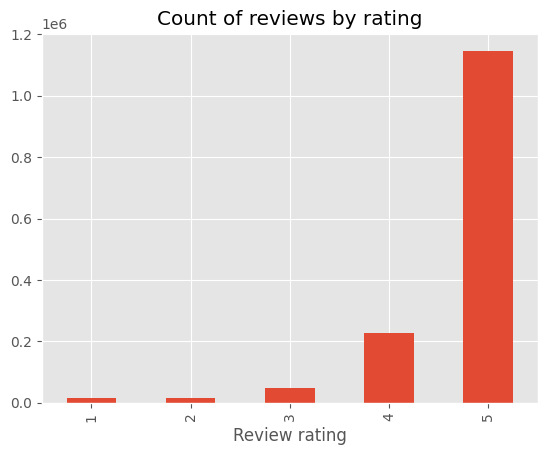

In [ ]:
# Przyjrzenie się ocenom szkoleń, wyrażonym pod każdym szkoleniem za pomocą przedziału liczb 1 - 5
ax = df["rating"].value_counts().sort_index().plot(kind="bar",\
                                              title="Count of reviews by rating")
ax.set_xlabel("Review rating")
plt.show()

In [ ]:
# Uzyskanie liczby danych klas
df["rating"].value_counts()

5    1146164
4     226702
3      48303
1      17354
2      16188
Name: rating, dtype: int64

In [ ]:
# Obliczenie liczby kursów, które uzyskały poszczególne ocey - w liczbach oraz procentach
rating = df.groupby("rating")["course_id"].count().reset_index()
rating["percentage"] = 100 * rating["rating"] / rating["rating"].sum()
rating

,rating,course_id,percentage
0,1,17354,6.666667
1,2,16188,13.333333
2,3,48303,20.000000
3,4,226702,26.666667
4,5,1146164,33.333333


In [ ]:
# Sprawdzenie ile komentarzy przypada na dane szkolenie
comments = df.course_id.value_counts()
comments

python                                        45218
machine-learning                              35895
neural-networks-deep-learning                 35750
technical-support-fundamentals                35319
python-data                                   33546
                                              ...  
social-economic-networks                          6
intro-to-healthcare                               6
entrepreneurship-strategy                         6
epigenetics                                       6
building-modern-python-applications-on-aws        3
Name: course_id, Length: 604, dtype: int64

In [ ]:
# Sprawdzenie długości komentarzy znjadujących się w kolumnie "reviews"
df['review_len'] = df['reviews'].apply(lambda x: len(str(x)))

In [ ]:
df['review_len']

0          346
1          245
2          224
3           83
4           80
          ... 
1454706      1
1454707      1
1454708      1
1454709      1
1454710      1
Name: review_len, Length: 1454711, dtype: int64

<Axes: ylabel='Frequency'>

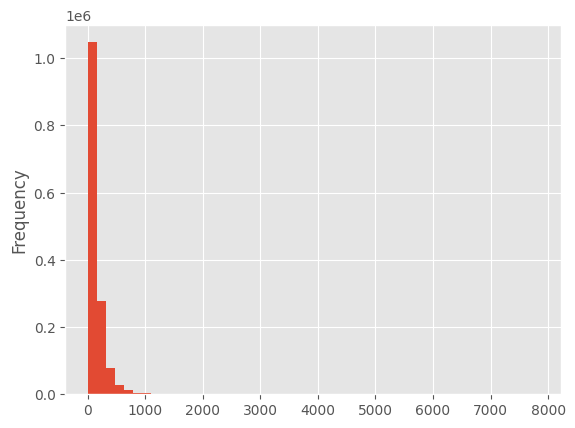

In [ ]:
df['review_len'].plot(bins=50, kind='hist')

# Część Druga  
## Metody NLTK  
- tokenizacja  
- znakowanie części mowy  
- grupowanie wyrażeń (chunking)  

In [ ]:
# Wybranie przykładu komentarza dotyczącego szkolenia
example = df["reviews"][7]
example

"Probably the best certification course I've taken in this respect. The course is planned out carefully, and I believe gave me everything I needed to ace my exam the first time around. The trainer for the majority of the course was awesome. She delivered the material in a great, professional mannor, but was never boring or monotoned. "

In [ ]:
# Potwierdzenie, że mój przykład jest pozytywny, a więc otrzymał dobrą ocenę (5)
df["rating"][7]

5

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Tokenizacja słów oraz wydrukowanie 10 pierwszycyh z powstałej listy
tokens = nltk.word_tokenize(example)
tokens[:10]

['Probably',
 'the',
 'best',
 'certification',
 'course',
 'I',
 "'ve",
 'taken',
 'in',
 'this']

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
# Znakowanie części mowy przy użyciu biblioteki nltk oraz 10 pierwszycyh elementów z powstałej listy
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('Probably', 'RB'),
 ('the', 'DT'),
 ('best', 'JJS'),
 ('certification', 'NN'),
 ('course', 'NN'),
 ('I', 'PRP'),
 ("'ve", 'VBP'),
 ('taken', 'VBN'),
 ('in', 'IN'),
 ('this', 'DT')]

In [ ]:
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [ ]:
# Sprawdzamy jakie kategorie istnieją w metodzie 
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  Probably/RB
  the/DT
  best/JJS
  certification/NN
  course/NN
  I/PRP
  've/VBP
  taken/VBN
  in/IN
  this/DT
  respect/NN
  ./.
  The/DT
  course/NN
  is/VBZ
  planned/VBN
  out/RP
  carefully/RB
  ,/,
  and/CC
  I/PRP
  believe/VBP
  gave/VBD
  me/PRP
  everything/NN
  I/PRP
  needed/VBD
  to/TO
  ace/VB
  my/PRP$
  exam/NN
  the/DT
  first/JJ
  time/NN
  around/RB
  ./.
  The/DT
  trainer/NN
  for/IN
  the/DT
  majority/NN
  of/IN
  the/DT
  course/NN
  was/VBD
  awesome/JJ
  ./.
  She/PRP
  delivered/VBD
  the/DT
  material/NN
  in/IN
  a/DT
  great/JJ
  ,/,
  professional/JJ
  mannor/NN
  ,/,
  but/CC
  was/VBD
  never/RB
  boring/JJ
  or/CC
  monotoned/VBN
  ./.)


# Część trzecia  
## Użycie metody VADER  
Metoda ta zwraca słownik z 4 parami, każdy klucz to wartość między -1, a 1 dla następujących sentymentów:   
- "pos" dla wskaźnika pozytywnego  
- "neu" dla wartości neutralnejo  
- "neg" dla wskaźnika negatywnego  
- "compound" - wynik polaryzacji całego zdania/tekstu. 
Jest to metoda ignorująca kontekst słów, oparta na tzw. metodzie "worka słów".

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
# importujemy instancję analizującą polaryzację podanych elementów (SentimentIntensityAnalyzer)
# oraz pomocną bibliotekę-tqdm-która pokazuje nam postęp wykonywania się petli w Pythonie
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
sia = SentimentIntensityAnalyzer()


In [ ]:
# Nadpisanie długość ramki z danymi z uwagi na zbyt dużą liczbę komentarzy?  -CZY ZROBIĆ TO TUTAJ CZY NA KOŃCU PRZY PORÓWNANIU

In [ ]:
# Zapisanie wyników polaryzacji dla każdego komentarza po kursie w utworzonej kolumnie "scores"
df["scores"] = df["reviews"].apply(lambda review: sia.polarity_scores(str(review)))
df.head(20)

,reviews,reviewers,date_reviews,rating,course_id,review_len,scores
0,"Pretty dry, but I was able to pass with just two complete watches so I'm happy about that. As usual there were some questions on the final exam that were NO WHERE in the course, which is annoying...",By Robert S,"Feb 12, 2020",4,google-cbrs-cpi-training,346,"{'neg': 0.102, 'neu': 0.738, 'pos': 0.16, 'compound': 0.644}"
1,would be a better experience if the video and screen shots would sho on the side of the text that the instructor is going thru so that user does not have to go all the way to beginning of text to ...,By Gabriel E R,"Sep 28, 2020",4,google-cbrs-cpi-training,245,"{'neg': 0.0, 'neu': 0.943, 'pos': 0.057, 'compound': 0.4404}"
2,Information was perfect! The program itself was a little annoying. I had to wait 30 to 45 minutes after watching the videos to to take the quiz. Other than that the information was perfect and pas...,By Jacob D,"Apr 08, 2020",4,google-cbrs-cpi-training,224,"{'neg': 0.097, 'neu': 0.735, 'pos': 0.168, 'compound': 0.6572}"
3,A few grammatical mistakes on test made me do a double take but all in all not bad.,By Dale B,"Feb 24, 2020",4,google-cbrs-cpi-training,83,"{'neg': 0.09, 'neu': 0.717, 'pos': 0.193, 'compound': 0.4633}"
4,Excellent course and the training provided was very detailed and easy to follow.,By Sean G,"Jun 18, 2020",4,google-cbrs-cpi-training,80,"{'neg': 0.0, 'neu': 0.616, 'pos': 0.384, 'compound': 0.7823}"
5,Some of the quizzes contained material not explicitly covered in the course.,By Daniel F,"Dec 23, 2019",4,google-cbrs-cpi-training,77,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
6,Solid presentation all the way through. I really appreciated the intermittent questions that popped up to check on learning as well the regular (but not needless) quizzing. There was visuals such ...,By Logan D,"Sep 03, 2020",5,google-cbrs-cpi-training,334,"{'neg': 0.0, 'neu': 0.835, 'pos': 0.165, 'compound': 0.8264}"
7,"Probably the best certification course I've taken in this respect. The course is planned out carefully, and I believe gave me everything I needed to ace my exam the first time around. The trainer ...",By Luis M C,"Nov 21, 2019",5,google-cbrs-cpi-training,335,"{'neg': 0.0, 'neu': 0.778, 'pos': 0.222, 'compound': 0.8935}"
8,The ProctorU.com system took 2 times the amount of time spent on this course over 3 days to complete. It is the worse production user system I have used in 20+ years of my IT career. You shoul...,By scott w,"Sep 28, 2020",5,google-cbrs-cpi-training,223,"{'neg': 0.075, 'neu': 0.925, 'pos': 0.0, 'compound': -0.4767}"
9,"Covered all of the required information in an easy to understand way and WITH VIDEO! Great, easy way to learn. The exam process was a bit drawn out and more extensive then it needed to be, but ove...",By Ryan H,"Aug 26, 2019",5,google-cbrs-cpi-training,220,"{'neg': 0.0, 'neu': 0.744, 'pos': 0.256, 'compound': 0.908}"


In [ ]:
# Odseparowanie kolumny ze wskażnikiem "compound"
df["compound"]  = df["scores"].apply(lambda score_dict: score_dict["compound"])
df.head(10)

,reviews,reviewers,date_reviews,rating,course_id,review_len,scores,compound
0,"Pretty dry, but I was able to pass with just two complete watches so I'm happy about that. As usual there were some questions on the final exam that were NO WHERE in the course, which is annoying...",By Robert S,"Feb 12, 2020",4,google-cbrs-cpi-training,346,"{'neg': 0.102, 'neu': 0.738, 'pos': 0.16, 'compound': 0.644}",0.6440
1,would be a better experience if the video and screen shots would sho on the side of the text that the instructor is going thru so that user does not have to go all the way to beginning of text to ...,By Gabriel E R,"Sep 28, 2020",4,google-cbrs-cpi-training,245,"{'neg': 0.0, 'neu': 0.943, 'pos': 0.057, 'compound': 0.4404}",0.4404
2,Information was perfect! The program itself was a little annoying. I had to wait 30 to 45 minutes after watching the videos to to take the quiz. Other than that the information was perfect and pas...,By Jacob D,"Apr 08, 2020",4,google-cbrs-cpi-training,224,"{'neg': 0.097, 'neu': 0.735, 'pos': 0.168, 'compound': 0.6572}",0.6572
3,A few grammatical mistakes on test made me do a double take but all in all not bad.,By Dale B,"Feb 24, 2020",4,google-cbrs-cpi-training,83,"{'neg': 0.09, 'neu': 0.717, 'pos': 0.193, 'compound': 0.4633}",0.4633
4,Excellent course and the training provided was very detailed and easy to follow.,By Sean G,"Jun 18, 2020",4,google-cbrs-cpi-training,80,"{'neg': 0.0, 'neu': 0.616, 'pos': 0.384, 'compound': 0.7823}",0.7823
5,Some of the quizzes contained material not explicitly covered in the course.,By Daniel F,"Dec 23, 2019",4,google-cbrs-cpi-training,77,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000
6,Solid presentation all the way through. I really appreciated the intermittent questions that popped up to check on learning as well the regular (but not needless) quizzing. There was visuals such ...,By Logan D,"Sep 03, 2020",5,google-cbrs-cpi-training,334,"{'neg': 0.0, 'neu': 0.835, 'pos': 0.165, 'compound': 0.8264}",0.8264
7,"Probably the best certification course I've taken in this respect. The course is planned out carefully, and I believe gave me everything I needed to ace my exam the first time around. The trainer ...",By Luis M C,"Nov 21, 2019",5,google-cbrs-cpi-training,335,"{'neg': 0.0, 'neu': 0.778, 'pos': 0.222, 'compound': 0.8935}",0.8935
8,The ProctorU.com system took 2 times the amount of time spent on this course over 3 days to complete. It is the worse production user system I have used in 20+ years of my IT career. You shoul...,By scott w,"Sep 28, 2020",5,google-cbrs-cpi-training,223,"{'neg': 0.075, 'neu': 0.925, 'pos': 0.0, 'compound': -0.4767}",-0.4767
9,"Covered all of the required information in an easy to understand way and WITH VIDEO! Great, easy way to learn. The exam process was a bit drawn out and more extensive then it needed to be, but ove...",By Ryan H,"Aug 26, 2019",5,google-cbrs-cpi-training,220,"{'neg': 0.0, 'neu': 0.744, 'pos': 0.256, 'compound': 0.908}",0.9080


In [ ]:
# Odseparowanie kolumny ze wskażnikiem "pos"
df["pos"]  = df["scores"].apply(lambda score_dict: score_dict["pos"])
df.head(10)

,reviews,reviewers,date_reviews,rating,course_id,review_len,scores,compound,pos
0,"Pretty dry, but I was able to pass with just two complete watches so I'm happy about that. As usual there were some questions on the final exam that were NO WHERE in the course, which is annoying...",By Robert S,"Feb 12, 2020",4,google-cbrs-cpi-training,346,"{'neg': 0.102, 'neu': 0.738, 'pos': 0.16, 'compound': 0.644}",0.6440,0.160
1,would be a better experience if the video and screen shots would sho on the side of the text that the instructor is going thru so that user does not have to go all the way to beginning of text to ...,By Gabriel E R,"Sep 28, 2020",4,google-cbrs-cpi-training,245,"{'neg': 0.0, 'neu': 0.943, 'pos': 0.057, 'compound': 0.4404}",0.4404,0.057
2,Information was perfect! The program itself was a little annoying. I had to wait 30 to 45 minutes after watching the videos to to take the quiz. Other than that the information was perfect and pas...,By Jacob D,"Apr 08, 2020",4,google-cbrs-cpi-training,224,"{'neg': 0.097, 'neu': 0.735, 'pos': 0.168, 'compound': 0.6572}",0.6572,0.168
3,A few grammatical mistakes on test made me do a double take but all in all not bad.,By Dale B,"Feb 24, 2020",4,google-cbrs-cpi-training,83,"{'neg': 0.09, 'neu': 0.717, 'pos': 0.193, 'compound': 0.4633}",0.4633,0.193
4,Excellent course and the training provided was very detailed and easy to follow.,By Sean G,"Jun 18, 2020",4,google-cbrs-cpi-training,80,"{'neg': 0.0, 'neu': 0.616, 'pos': 0.384, 'compound': 0.7823}",0.7823,0.384
5,Some of the quizzes contained material not explicitly covered in the course.,By Daniel F,"Dec 23, 2019",4,google-cbrs-cpi-training,77,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,0.000
6,Solid presentation all the way through. I really appreciated the intermittent questions that popped up to check on learning as well the regular (but not needless) quizzing. There was visuals such ...,By Logan D,"Sep 03, 2020",5,google-cbrs-cpi-training,334,"{'neg': 0.0, 'neu': 0.835, 'pos': 0.165, 'compound': 0.8264}",0.8264,0.165
7,"Probably the best certification course I've taken in this respect. The course is planned out carefully, and I believe gave me everything I needed to ace my exam the first time around. The trainer ...",By Luis M C,"Nov 21, 2019",5,google-cbrs-cpi-training,335,"{'neg': 0.0, 'neu': 0.778, 'pos': 0.222, 'compound': 0.8935}",0.8935,0.222
8,The ProctorU.com system took 2 times the amount of time spent on this course over 3 days to complete. It is the worse production user system I have used in 20+ years of my IT career. You shoul...,By scott w,"Sep 28, 2020",5,google-cbrs-cpi-training,223,"{'neg': 0.075, 'neu': 0.925, 'pos': 0.0, 'compound': -0.4767}",-0.4767,0.000
9,"Covered all of the required information in an easy to understand way and WITH VIDEO! Great, easy way to learn. The exam process was a bit drawn out and more extensive then it needed to be, but ove...",By Ryan H,"Aug 26, 2019",5,google-cbrs-cpi-training,220,"{'neg': 0.0, 'neu': 0.744, 'pos': 0.256, 'compound': 0.908}",0.9080,0.256


In [ ]:
# Odseparowanie kolumny ze wskażnikiem "neg"
df["neg"]  = df["scores"].apply(lambda score_dict: score_dict["neg"])
df.head(10)

,reviews,reviewers,date_reviews,rating,course_id,review_len,scores,compound,pos,neg
0,"Pretty dry, but I was able to pass with just two complete watches so I'm happy about that. As usual there were some questions on the final exam that were NO WHERE in the course, which is annoying...",By Robert S,"Feb 12, 2020",4,google-cbrs-cpi-training,346,"{'neg': 0.102, 'neu': 0.738, 'pos': 0.16, 'compound': 0.644}",0.6440,0.160,0.102
1,would be a better experience if the video and screen shots would sho on the side of the text that the instructor is going thru so that user does not have to go all the way to beginning of text to ...,By Gabriel E R,"Sep 28, 2020",4,google-cbrs-cpi-training,245,"{'neg': 0.0, 'neu': 0.943, 'pos': 0.057, 'compound': 0.4404}",0.4404,0.057,0.000
2,Information was perfect! The program itself was a little annoying. I had to wait 30 to 45 minutes after watching the videos to to take the quiz. Other than that the information was perfect and pas...,By Jacob D,"Apr 08, 2020",4,google-cbrs-cpi-training,224,"{'neg': 0.097, 'neu': 0.735, 'pos': 0.168, 'compound': 0.6572}",0.6572,0.168,0.097
3,A few grammatical mistakes on test made me do a double take but all in all not bad.,By Dale B,"Feb 24, 2020",4,google-cbrs-cpi-training,83,"{'neg': 0.09, 'neu': 0.717, 'pos': 0.193, 'compound': 0.4633}",0.4633,0.193,0.090
4,Excellent course and the training provided was very detailed and easy to follow.,By Sean G,"Jun 18, 2020",4,google-cbrs-cpi-training,80,"{'neg': 0.0, 'neu': 0.616, 'pos': 0.384, 'compound': 0.7823}",0.7823,0.384,0.000
5,Some of the quizzes contained material not explicitly covered in the course.,By Daniel F,"Dec 23, 2019",4,google-cbrs-cpi-training,77,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,0.000,0.000
6,Solid presentation all the way through. I really appreciated the intermittent questions that popped up to check on learning as well the regular (but not needless) quizzing. There was visuals such ...,By Logan D,"Sep 03, 2020",5,google-cbrs-cpi-training,334,"{'neg': 0.0, 'neu': 0.835, 'pos': 0.165, 'compound': 0.8264}",0.8264,0.165,0.000
7,"Probably the best certification course I've taken in this respect. The course is planned out carefully, and I believe gave me everything I needed to ace my exam the first time around. The trainer ...",By Luis M C,"Nov 21, 2019",5,google-cbrs-cpi-training,335,"{'neg': 0.0, 'neu': 0.778, 'pos': 0.222, 'compound': 0.8935}",0.8935,0.222,0.000
8,The ProctorU.com system took 2 times the amount of time spent on this course over 3 days to complete. It is the worse production user system I have used in 20+ years of my IT career. You shoul...,By scott w,"Sep 28, 2020",5,google-cbrs-cpi-training,223,"{'neg': 0.075, 'neu': 0.925, 'pos': 0.0, 'compound': -0.4767}",-0.4767,0.000,0.075
9,"Covered all of the required information in an easy to understand way and WITH VIDEO! Great, easy way to learn. The exam process was a bit drawn out and more extensive then it needed to be, but ove...",By Ryan H,"Aug 26, 2019",5,google-cbrs-cpi-training,220,"{'neg': 0.0, 'neu': 0.744, 'pos': 0.256, 'compound': 0.908}",0.9080,0.256,0.000


In [ ]:
# Odseparowanie kolumny ze wskażnikiem "neu"
df["neu"]  = df["scores"].apply(lambda score_dict: score_dict["neu"])
df.head(10)

,reviews,reviewers,date_reviews,rating,course_id,review_len,scores,compound,pos,neg,neu
0,"Pretty dry, but I was able to pass with just two complete watches so I'm happy about that. As usual there were some questions on the final exam that were NO WHERE in the course, which is annoying...",By Robert S,"Feb 12, 2020",4,google-cbrs-cpi-training,346,"{'neg': 0.102, 'neu': 0.738, 'pos': 0.16, 'compound': 0.644}",0.6440,0.160,0.102,0.738
1,would be a better experience if the video and screen shots would sho on the side of the text that the instructor is going thru so that user does not have to go all the way to beginning of text to ...,By Gabriel E R,"Sep 28, 2020",4,google-cbrs-cpi-training,245,"{'neg': 0.0, 'neu': 0.943, 'pos': 0.057, 'compound': 0.4404}",0.4404,0.057,0.000,0.943
2,Information was perfect! The program itself was a little annoying. I had to wait 30 to 45 minutes after watching the videos to to take the quiz. Other than that the information was perfect and pas...,By Jacob D,"Apr 08, 2020",4,google-cbrs-cpi-training,224,"{'neg': 0.097, 'neu': 0.735, 'pos': 0.168, 'compound': 0.6572}",0.6572,0.168,0.097,0.735
3,A few grammatical mistakes on test made me do a double take but all in all not bad.,By Dale B,"Feb 24, 2020",4,google-cbrs-cpi-training,83,"{'neg': 0.09, 'neu': 0.717, 'pos': 0.193, 'compound': 0.4633}",0.4633,0.193,0.090,0.717
4,Excellent course and the training provided was very detailed and easy to follow.,By Sean G,"Jun 18, 2020",4,google-cbrs-cpi-training,80,"{'neg': 0.0, 'neu': 0.616, 'pos': 0.384, 'compound': 0.7823}",0.7823,0.384,0.000,0.616
5,Some of the quizzes contained material not explicitly covered in the course.,By Daniel F,"Dec 23, 2019",4,google-cbrs-cpi-training,77,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,0.000,0.000,1.000
6,Solid presentation all the way through. I really appreciated the intermittent questions that popped up to check on learning as well the regular (but not needless) quizzing. There was visuals such ...,By Logan D,"Sep 03, 2020",5,google-cbrs-cpi-training,334,"{'neg': 0.0, 'neu': 0.835, 'pos': 0.165, 'compound': 0.8264}",0.8264,0.165,0.000,0.835
7,"Probably the best certification course I've taken in this respect. The course is planned out carefully, and I believe gave me everything I needed to ace my exam the first time around. The trainer ...",By Luis M C,"Nov 21, 2019",5,google-cbrs-cpi-training,335,"{'neg': 0.0, 'neu': 0.778, 'pos': 0.222, 'compound': 0.8935}",0.8935,0.222,0.000,0.778
8,The ProctorU.com system took 2 times the amount of time spent on this course over 3 days to complete. It is the worse production user system I have used in 20+ years of my IT career. You shoul...,By scott w,"Sep 28, 2020",5,google-cbrs-cpi-training,223,"{'neg': 0.075, 'neu': 0.925, 'pos': 0.0, 'compound': -0.4767}",-0.4767,0.000,0.075,0.925
9,"Covered all of the required information in an easy to understand way and WITH VIDEO! Great, easy way to learn. The exam process was a bit drawn out and more extensive then it needed to be, but ove...",By Ryan H,"Aug 26, 2019",5,google-cbrs-cpi-training,220,"{'neg': 0.0, 'neu': 0.744, 'pos': 0.256, 'compound': 0.908}",0.9080,0.256,0.000,0.744


In [ ]:
# Dodanie kolumny, która interpretuje wynik złożony (compound score) jako pozytywny lub negatywny
df["comp_score"] = df["compound"].apply(lambda c: "pos" if c >=0 else "neg")
df.head(4)

,reviews,reviewers,date_reviews,rating,course_id,review_len,scores,compound,pos,neg,neu,comp_score
0,"Pretty dry, but I was able to pass with just two complete watches so I'm happy about that. As usual there were some questions on the final exam that were NO WHERE in the course, which is annoying...",By Robert S,"Feb 12, 2020",4,google-cbrs-cpi-training,346,"{'neg': 0.102, 'neu': 0.738, 'pos': 0.16, 'compound': 0.644}",0.6440,0.160,0.102,0.738,pos
1,would be a better experience if the video and screen shots would sho on the side of the text that the instructor is going thru so that user does not have to go all the way to beginning of text to ...,By Gabriel E R,"Sep 28, 2020",4,google-cbrs-cpi-training,245,"{'neg': 0.0, 'neu': 0.943, 'pos': 0.057, 'compound': 0.4404}",0.4404,0.057,0.000,0.943,pos
2,Information was perfect! The program itself was a little annoying. I had to wait 30 to 45 minutes after watching the videos to to take the quiz. Other than that the information was perfect and pas...,By Jacob D,"Apr 08, 2020",4,google-cbrs-cpi-training,224,"{'neg': 0.097, 'neu': 0.735, 'pos': 0.168, 'compound': 0.6572}",0.6572,0.168,0.097,0.735,pos
3,A few grammatical mistakes on test made me do a double take but all in all not bad.,By Dale B,"Feb 24, 2020",4,google-cbrs-cpi-training,83,"{'neg': 0.09, 'neu': 0.717, 'pos': 0.193, 'compound': 0.4633}",0.4633,0.193,0.090,0.717,pos


In [ ]:
python_course = df[df.course_id == "python"]
python_course.reset_index(inplace=True)
python_course.head(5)

,index,reviews,reviewers,date_reviews,rating,course_id,review_len,scores,compound,pos,neg,neu,comp_score
0,15727,I did not find this course helpful. The assignments seem to ask for more info that you've been taught in any of the videos. My analogy for the course is this: It's like making a newborn baby watch...,By Eric V H,"Oct 05, 2017",1,python,476,"{'neg': 0.073, 'neu': 0.868, 'pos': 0.058, 'compound': -0.0946}",-0.0946,0.058,0.073,0.868,neg
1,15728,"I got a 95% and maybe I learned something but I can honestly say it wasn't because I watched the videos - the professor is seriously disconnected. Programming for ""Everybody""? I know what I want t...",By Connor B,"Aug 06, 2017",1,python,376,"{'neg': 0.073, 'neu': 0.845, 'pos': 0.082, 'compound': 0.1531}",0.1531,0.082,0.073,0.845,pos
2,15729,"Two weeks of all sort of nonsense, including macarena, Harry Potter, sorting hat, videos of meaningless travels and lots of self-promotion. Pure crap that doesn´t worth anybody´s time. When theory...",By Cyntia R T G,"Mar 28, 2019",1,python,375,"{'neg': 0.227, 'neu': 0.711, 'pos': 0.061, 'compound': -0.8718}",-0.8718,0.061,0.227,0.711,neg
3,15730,We tried to use this class to teach a brown bag lunch for our employees interested in programming. Python is a great language but this class has a very low content to volume ratio (nobody wants t...,By Steve M,"Oct 20, 2015",1,python,335,"{'neg': 0.052, 'neu': 0.874, 'pos': 0.074, 'compound': 0.0799}",0.0799,0.074,0.052,0.874,pos
4,15731,"To be honest, I thought the course stumbled and fell short. It was too basic and slow paced. The tone was a bit immature at times, and perhaps appropriate only for a grade school level classroom...",By Terence P,"May 11, 2016",1,python,1328,"{'neg': 0.094, 'neu': 0.795, 'pos': 0.11, 'compound': 0.6191}",0.6191,0.110,0.094,0.795,pos


<Axes: xlabel='rating', ylabel='compound'>

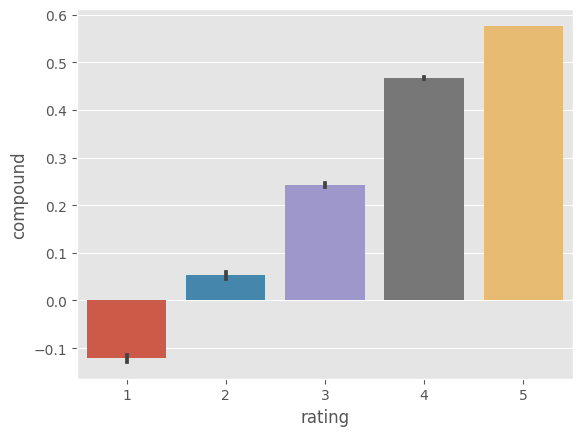

In [ ]:
# Wizualizacja ocen szkoleń (przedział 1 - 5) oraz wyniku zbiorowego "compound" (-1 do +1)
sns.barplot(data=df, x="rating", y="compound")

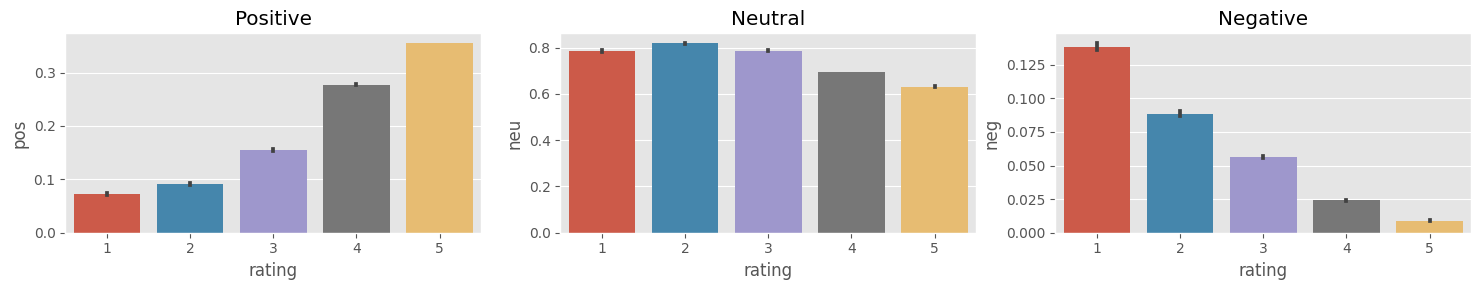

In [ ]:
# Wizualizacja jak wypadają wskaźniki uzyskane przy pomocy narzędzia VADER, a liczbowe oceny uczestników
fig, axs = plt.subplots(1, 3, figsize=(15,3))
sns.barplot(data=df, x="rating", y="pos", ax=axs[0])
sns.barplot(data=df, x="rating", y="neu", ax=axs[1])
sns.barplot(data=df, x="rating", y="neg", ax=axs[2])
axs[0].set_title("Positive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")
plt.tight_layout()
plt.show()

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.8 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
# Przypomnienie przykładu zapisanego fragmentu korpusa
example

"Probably the best certification course I've taken in this respect. The course is planned out carefully, and I believe gave me everything I needed to ace my exam the first time around. The trainer for the majority of the course was awesome. She delivered the material in a great, professional mannor, but was never boring or monotoned. "

In [ ]:
# Sprawdzenie wyniku polaryzacji przykładu przez metodę VADER, 0,89 dla "compound" to bardzo pozytywny wynik 
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.778, 'pos': 0.222, 'compound': 0.8935}

In [ ]:
# Zdefiniowanie funkcji analizującej sentyment z użyciem modelu RoBERTa
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, truncation=True, max_length=512, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
# Sprawdzenie polaryzacji przy użyciu modelu RoBERTa
polarity_scores_roberta(example)

{'roberta_neg': 0.002177273,
 'roberta_neu': 0.019883221,
 'roberta_pos': 0.97793955}

### Ten fragment kodu służył do zmiejszenia zestawu danych z uwagi na ogroniczenia czasowe - kod nie został ukończony po 10 godzinach pracy przy wykupionej wersji Pro

In [ ]:
def split_df(dataframe, rating, length):
  new_df = pd.DataFrame()
  try:
    new_df = dataframe[dataframe["rating"] == rating]
    # print(new_df)
  except: #błąd do obsłużenia później
    pass
  return new_df.head(length)

In [ ]:
neg = split_df(df, 1, 10000).append(split_df(df, 2, 10000))
neu = split_df(df, 3, 10000)
pos = split_df(df, 4, 10000).append(split_df(df, 5, 10000))
temp_res = neg.append(neu)
copy_df = temp_res.append(pos)
copy_df.shape

<ipython-input-54-3845e944fb6c>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg = split_df(df, 1, 10000).append(split_df(df, 2, 10000))
<ipython-input-54-3845e944fb6c>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pos = split_df(df, 4, 10000).append(split_df(df, 5, 10000))
<ipython-input-54-3845e944fb6c>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp_res = neg.append(neu)
<ipython-input-54-3845e944fb6c>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  copy_df = temp_res.append(pos)


(50000, 12)

In [ ]:
df["rating"].value_counts()

5    1146164
4     226702
3      48303
1      17354
2      16188
Name: rating, dtype: int64

In [56]:
# Sprawdzenie wyników polaryzacji dla każdego komentarza po kursie w utworzonej kolumnie "roberta_scores" dla 15000 komentarzy
# copy_df = df[:10000].copy()
copy_df["roberta_scores"] = copy_df["reviews"].apply(lambda review: polarity_scores_roberta(str(review)))


In [57]:
copy_df.head(3)

,reviews,reviewers,date_reviews,rating,course_id,review_len,scores,compound,pos,neg,neu,comp_score,roberta_scores
87,"This course is virtually worthless. I couldn't follow the lectures, and I have a PhD and have been a tenured professor for almost two decades. The online course is based on snippets taken from fac...",By James R,"Apr 23, 2019",1,financial-markets-global,961,"{'neg': 0.096, 'neu': 0.875, 'pos': 0.029, 'compound': -0.8957}",-0.8957,0.029,0.096,0.875,neg,"{'roberta_neg': 0.9098781, 'roberta_neu': 0.07951089, 'roberta_pos': 0.010610986}"
88,"This course was horrible! The Content was very disoriented and unclear. Videos were distorted, and jumping from one topic to another. There was no sense of continuity. One can not say this was a c...",By Sanam P,"Oct 22, 2017",1,financial-markets-global,214,"{'neg': 0.307, 'neu': 0.693, 'pos': 0.0, 'compound': -0.9144}",-0.9144,0.000,0.307,0.693,neg,"{'roberta_neg': 0.9599646, 'roberta_neu': 0.036168974, 'roberta_pos': 0.0038664935}"
89,Terrible lecturer. Maybe he should retire. He can't stay on point. Lectures are unwatchable - except for the beautiful auditorium stage.,By Brendan F,"Jan 29, 2019",1,financial-markets-global,136,"{'neg': 0.124, 'neu': 0.72, 'pos': 0.156, 'compound': 0.2023}",0.2023,0.156,0.124,0.720,pos,"{'roberta_neg': 0.96066827, 'roberta_neu': 0.0342887, 'roberta_pos': 0.00504299}"


In [58]:
# Spojrzenie na kolumnę "rating" - ocena oraz wyników RoBERTa
copy_df[["rating", "roberta_scores"]].sample(10)

,rating,roberta_scores
8281,5,"{'roberta_neg': 0.060793437, 'roberta_neu': 0.32942787, 'roberta_pos': 0.60977864}"
169342,3,"{'roberta_neg': 0.09341939, 'roberta_neu': 0.27355984, 'roberta_pos': 0.6330208}"
4000,5,"{'roberta_neg': 0.0038789269, 'roberta_neu': 0.083257385, 'roberta_pos': 0.9128637}"
4194,5,"{'roberta_neg': 0.0019052139, 'roberta_neu': 0.010848515, 'roberta_pos': 0.9872463}"
567935,2,"{'roberta_neg': 0.70807195, 'roberta_neu': 0.24512063, 'roberta_pos': 0.046807315}"
338664,3,"{'roberta_neg': 0.09526577, 'roberta_neu': 0.3949837, 'roberta_pos': 0.50975055}"
517282,2,"{'roberta_neg': 0.034600187, 'roberta_neu': 0.4167589, 'roberta_pos': 0.54864097}"
16850,3,"{'roberta_neg': 0.16966106, 'roberta_neu': 0.6786339, 'roberta_pos': 0.15170504}"
73695,1,"{'roberta_neg': 0.6033763, 'roberta_neu': 0.37396508, 'roberta_pos': 0.022658577}"
507,4,"{'roberta_neg': 0.0045958688, 'roberta_neu': 0.18732426, 'roberta_pos': 0.8080799}"


In [59]:
# Rozbicie słownika z zapisanymi wynikami analizy polaryzacji 
copy_df["roberta_neg"] = copy_df["roberta_scores"].apply(lambda score_dict: score_dict["roberta_neg"])
copy_df["roberta_neu"] = copy_df["roberta_scores"].apply(lambda score_dict: score_dict["roberta_neu"])
copy_df["roberta_pos"] = copy_df["roberta_scores"].apply(lambda score_dict: score_dict["roberta_pos"])

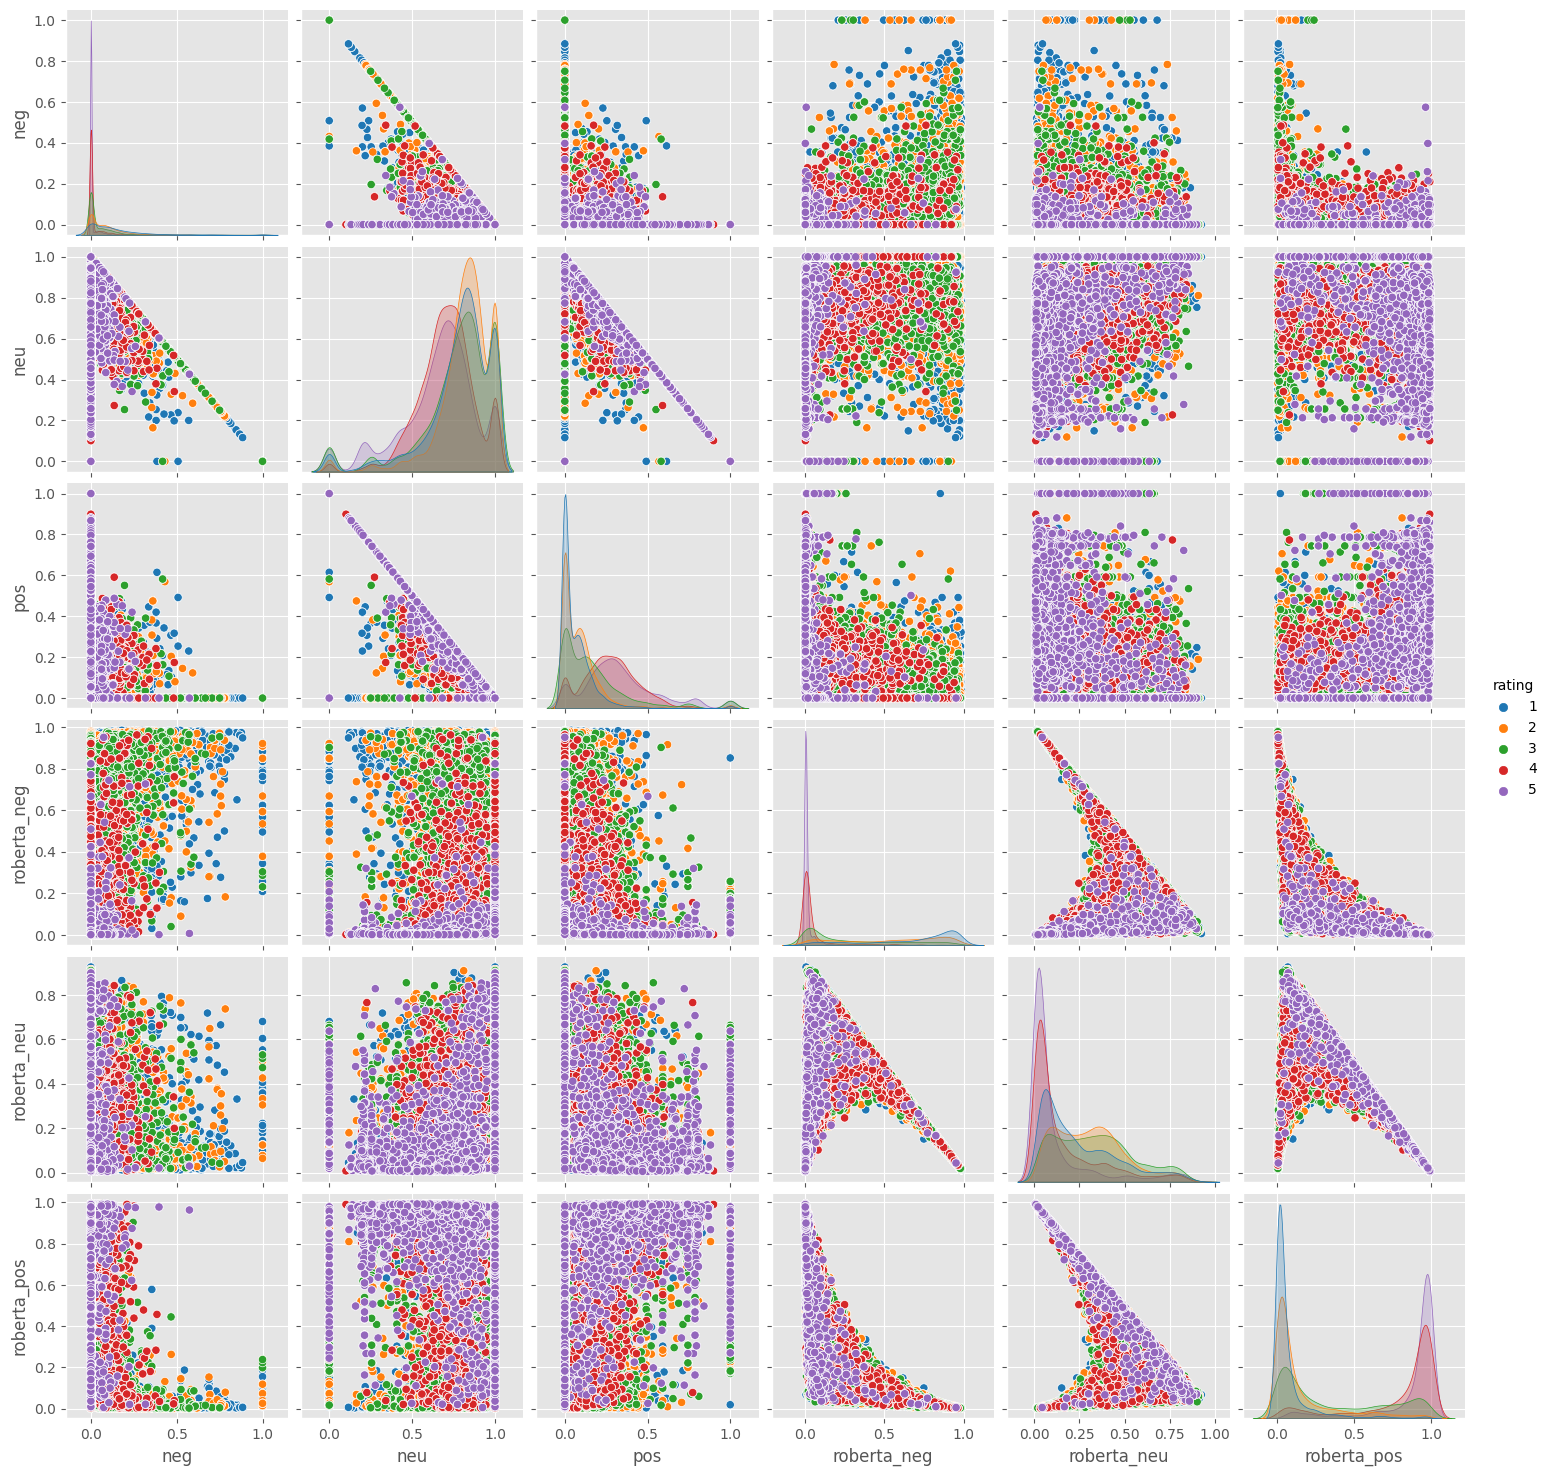

In [68]:
# Porównanie użytych modeli
sns.pairplot(data=copy_df,
             vars=['neg', 'neu', 'pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='rating',
            palette='tab10')
plt.show()

### Zliczenie wyników analizy, w celu porównania ilości komentarzy:
1. VADER - zaklasyfikowane etykiety pozytywne, negatywne neutralne oraz rozbicie c*ompound score*
2. RoBERTa

In [71]:
# Liczba komentarzy pozytywnych VADER vs RoBERTa
positive_vader = copy_df[copy_df["pos"] >= 0.51]
positive_roberta = copy_df[copy_df["roberta_pos"] >= 0.51]
len(positive_vader), len(positive_roberta)

(3931, 22261)

In [72]:
# Liczba pozytywnych próbek - zakategoryzowanych przez VADER
len(df["pos"])

1454711

In [65]:
# Liczba neutralnych próbek - zakategoryzowanych przez VADER
len(df["neu"])

1454711

In [66]:
# Liczba negatywnych próbek - zakategoryzowanych przez VADER
len(df["neg"])

1454711

In [112]:
# Wzięcie pod uwagę wyniku compound score - do 0,2 dla etykiety 1, do 0,4 dla etykiety 2 itd.
vader_score_1 = df[df.compound < 0.2]
vader_score_2 = df[(df.compound > 0.2) & (df.compound <= 0.4)]
vader_score_3 = df[(df.compound > 0.4) & (df.compound <= 0.6)]
vader_score_4 = df[(df.compound > 0.6) & (df.compound <= 0.8)]
vader_score_5 = df[(df.compound > 0.8)]

print(f"""Liczba wyników dla poszczególnych kategorii to:
- dla 1: {len(vader_score_1)},
- dla 2 - {len(vader_score_2)},
- dla 3: {len(vader_score_3)},
- dla 4 - {len(vader_score_4)},
- dla 5: {len(vader_score_5)},
Suma wszystkich to {len(df["compound"])}.
""")

Liczba wyników dla poszczególnych kategorii to:
- dla 1: 290769,
- dla 2 - 69624,
- dla 3: 311984,
- dla 4 - 376802,
- dla 5: 405532,
Suma wszystkich to 1454711.



In [114]:
# Wzięcie pod uwagę wyniku compound score - dla zestawy copy_df
vader_score_1 = copy_df[copy_df.compound < 0.2]
vader_score_2 = copy_df[(copy_df.compound > 0.2) & (copy_df.compound <= 0.4)]
vader_score_3 = copy_df[(copy_df.compound > 0.4) & (copy_df.compound <= 0.6)]
vader_score_4 = copy_df[(copy_df.compound > 0.6) & (copy_df.compound <= 0.8)]
vader_score_5 = copy_df[(copy_df.compound > 0.8)]

print(f"""Liczba wyników dla poszczególnych kategorii to:
- dla 1: {len(vader_score_1)},
- dla 2 - {len(vader_score_2)},
- dla 3: {len(vader_score_3)},
- dla 4 - {len(vader_score_4)},
- dla 5: {len(vader_score_5)},
Suma wszystkich to {len(copy_df["compound"])}.
""")

Liczba wyników dla poszczególnych kategorii to:
- dla 1: 20695,
- dla 2 - 3447,
- dla 3: 8050,
- dla 4 - 8392,
- dla 5: 9416,
Suma wszystkich to 50000.



In [80]:
copy_df.columns

Index(['reviews', 'reviewers', 'date_reviews', 'rating', 'course_id',
       'review_len', 'scores', 'compound', 'pos', 'neg', 'neu', 'comp_score',
       'roberta_scores', 'roberta_neg', 'roberta_neu', 'roberta_pos'],
      dtype='object')

In [105]:
# Analiza jak wyglądają ułamki dla różncych wyników
copy_df["roberta_scores"].sample(15)

594034       {'roberta_neg': 0.7839969, 'roberta_neu': 0.19807367, 'roberta_pos': 0.017929468}
234321       {'roberta_neg': 0.40243196, 'roberta_neu': 0.47202197, 'roberta_pos': 0.12554614}
605203      {'roberta_neg': 0.78941345, 'roberta_neu': 0.18972974, 'roberta_pos': 0.020856867}
112500        {'roberta_neg': 0.21047427, 'roberta_neu': 0.5157348, 'roberta_pos': 0.27379096}
10174      {'roberta_neg': 0.001329844, 'roberta_neu': 0.013832423, 'roberta_pos': 0.98483765}
5139       {'roberta_neg': 0.0019245183, 'roberta_neu': 0.011854832, 'roberta_pos': 0.9862206}
20498       {'roberta_neg': 0.038426332, 'roberta_neu': 0.24855411, 'roberta_pos': 0.71301955}
25276       {'roberta_neg': 0.006541781, 'roberta_neu': 0.10767848, 'roberta_pos': 0.88577974}
567931    {'roberta_neg': 0.96950936, 'roberta_neu': 0.028051032, 'roberta_pos': 0.0024397192}
3905        {'roberta_neg': 0.0032038486, 'roberta_neu': 0.03294102, 'roberta_pos': 0.9638552}
25226       {'roberta_neg': 0.006541781, 'roberta_

In [107]:
# Dodanie najwyższego wyniku poprzed porównanie 3 kolumn dla modelu RoBERTa
copy_df["Max"] = copy_df[["roberta_neg","roberta_neu", "roberta_neg"]].idxmax(axis=1)

In [108]:
# Pogląd utworzonej kolumn "Max"
copy_df["Max"].sample(10)

23891     roberta_neu
9093      roberta_neu
434191    roberta_neg
11675     roberta_neu
5679      roberta_neu
381652    roberta_neg
16072     roberta_neg
9511      roberta_neu
24480     roberta_neu
442522    roberta_neg
Name: Max, dtype: object

In [110]:
# Zliczanie wyników dla modelu RoBERTa
roberta_score_1 = copy_df["roberta_neg"].value_counts()
roberta_score_2 = copy_df["roberta_neu"].value_counts()
roberta_score_3 = copy_df["roberta_pos"].value_counts()

print(f"""Liczba wyników dla poszczególnych kategorii to:
- dla 1: {len(roberta_score_1)},
- dla 2 - {len(vader_score_2)},
- dla 3: {len(vader_score_3)},
Suma wszystkich to {copy_df["roberta_scores"].shape[0]}.""")

Liczba wyników dla poszczególnych kategorii to:
- dla 1: 17814,
- dla 2 - 69624,
- dla 3: 311984,
Suma wszystkich to 50000.


In [ ]:
neg_rating = copy_df[(copy_df["rating"] == 1) | (copy_df["rating"] == 2)]
len(neg_rating)